In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
## Step 1: Load and Preprocess Data
# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for pre-trained model input
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization for pre-trained models
])

In [3]:
!unzip -qq ./chip_data.zip -d data

In [4]:
dataset_path = "./data/dataset/"
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)

In [5]:
def show_sample_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(5, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # Convert tensor format (C, H, W) to (H, W, C)
        axes[i].imshow(image)
        axes[i].set_title(dataset.classes[label])
        axes[i].axis("off")
    plt.show()

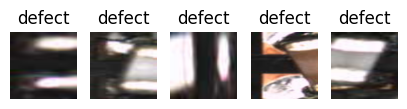

In [6]:
show_sample_images(train_dataset)

In [7]:
print(f"Total number of training samples: {len(train_dataset)}")

# Get the shape of the first image in the dataset
first_image, label = train_dataset[0]
print(f"Shape of the first image: {first_image.shape}")

Total number of training samples: 172
Shape of the first image: torch.Size([3, 224, 224])


In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
## Step 2: Load Pretrained Model and Modify for Transfer Learning
# Load a pre-trained VGG19 model
from torchvision.models import VGG19_Weights
model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:08<00:00, 70.7MB/s]


In [12]:
from torchsummary import summary
# Print model summary
summary(model, input_size=(3, 224, 224), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [13]:
# Modify the final fully connected layer to match the dataset classes
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, 1)

In [14]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [15]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [16]:
# Freeze all layers except the final layer
for param in model.features.parameters():
    param.requires_grad = False  # Freeze feature extractor layers

In [17]:
# Include the Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
## Step 3: Train the Model
def train_model(model, train_loader,test_loader,num_epochs=10):
    train_losses = []
    val_losses = []
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float()) # Reshape labels and convert to float
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Compute validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels.unsqueeze(1).float()) # Reshape labels and convert to float
                val_loss += loss.item()

        val_losses.append(val_loss / len(test_loader))
        model.train()

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    # Plot training and validation loss
    print("Name: K MADHAVA REDDY")
    print("Register Number: 212223240064")
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    return model

In [19]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Epoch [1/10], Train Loss: 1.1688, Validation Loss: 0.3099
Epoch [2/10], Train Loss: 0.2274, Validation Loss: 0.1671
Epoch [3/10], Train Loss: 0.1343, Validation Loss: 0.0944
Epoch [4/10], Train Loss: 0.0168, Validation Loss: 0.0806
Epoch [5/10], Train Loss: 0.0196, Validation Loss: 0.0949
Epoch [6/10], Train Loss: 0.0124, Validation Loss: 0.3525
Epoch [7/10], Train Loss: 0.0241, Validation Loss: 0.3217
Epoch [8/10], Train Loss: 0.0166, Validation Loss: 0.1729
Epoch [9/10], Train Loss: 0.0659, Validation Loss: 0.0967
Epoch [10/10], Train Loss: 0.1606, Validation Loss: 2.1628
Name: K MADHAVA REDDY
Register Number: 212223240064


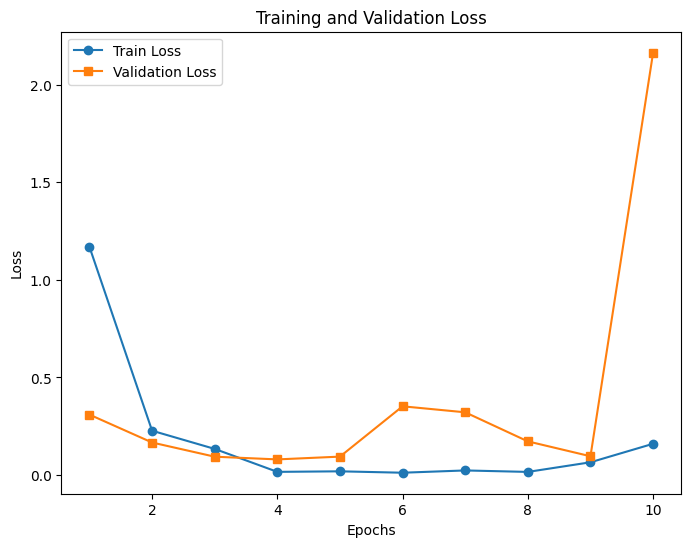

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [20]:
train_model(model,train_loader,test_loader)

In [21]:
## Step 4: Test the Model and Compute Confusion Matrix & Classification Report
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Name: K MADHAVA REDDY")
    print("Register Number: 212223240064")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("Name: K MADHAVA REDDY")
    print("Register Number: 212223240064")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

Test Accuracy: 0.2727
Name: K MADHAVA REDDY
Register Number: 212223240064


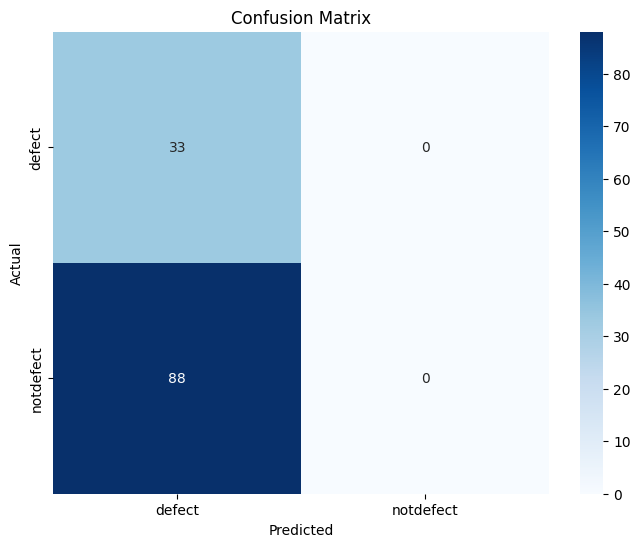

Name: K MADHAVA REDDY
Register Number: 212223240064
Classification Report:
              precision    recall  f1-score   support

      defect       0.27      1.00      0.43        33
   notdefect       0.00      0.00      0.00        88

    accuracy                           0.27       121
   macro avg       0.14      0.50      0.21       121
weighted avg       0.07      0.27      0.12       121



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
# Test the model
test_model(model, test_loader)

In [24]:
def predict_image(model, image_index, dataset):
    model.eval()
    image, label = dataset[image_index]
    with torch.no_grad():
        image_tensor = image.unsqueeze(0).to(device)
        output = model(image_tensor)

        # Apply sigmoid to get probability, threshold at 0.5
        prob = torch.sigmoid(output)
        predicted = (prob > 0.5).int().item()


    class_names = class_names = dataset.classes
    # Display the image
    image_to_display = transforms.ToPILImage()(image)
    plt.figure(figsize=(4, 4))
    plt.imshow(image_to_display)
    plt.title(f'Actual: {class_names[label]}\nPredicted: {class_names[predicted]}')
    plt.axis("off")
    plt.show()

    print(f'Actual: {class_names[label]}, Predicted: {class_names[predicted]}')

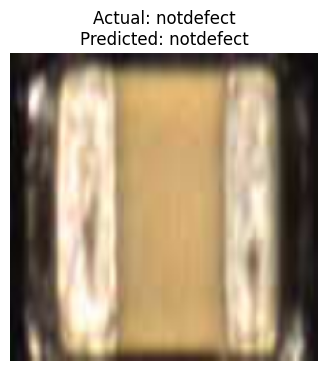

Actual: notdefect, Predicted: notdefect


In [25]:
predict_image(model, image_index=46, dataset=test_dataset)

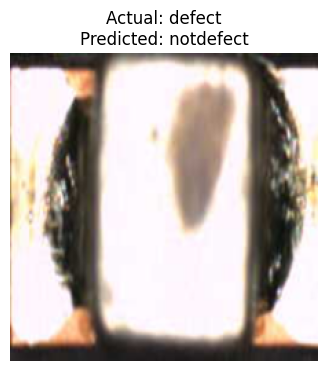

Actual: defect, Predicted: notdefect


In [26]:
predict_image(model, image_index=9, dataset=test_dataset)